In [1]:
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
import os 
from CeramicsPreprocessorRGK import CeramicsPreprocessorRGK
from FourierDescriptorMagnitude import FourierDescriptorMagnitude
from FourierDescriptorPhase import FourierDescriptorPhase
from fourier_utils import *
import matplotlib as mpl
from curvature import Curvature
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## Define helper functions

In [2]:
def filenames_to_classes(full_filename:str):
    """
    very basic function to convert filenames into class labels
    """
    filename = full_filename.split('/')
    name_to_label = {
        'B':0,
        'K':1,
        'R':2,
    }
    return name_to_label.get(filename[-1][0])



## Define path with shape images and preprocess to binary image

In [3]:
#path = "/home/michael/Downloads/miningshapes_cleaned"#"/home/michael/Desktop/test"
#path = "/home/michael/Desktop/test/"
bin_path = '/home/images/37_RGK_conspectus/binaries'
orig_path = '/home/images/test'
#dest_path = "/home/michael/Desktop/conspect_bin/"
#preprocessor = CeramicsPreprocessorRGK(path,['.png'])
#out = preprocessor.run()
images = []
origs = []
labels = []
#print(len(out[0]))
files_p = os.listdir(bin_path)
for fname in files_p:
    origs.append(cv.imread(os.path.join(orig_path,fname), cv.IMREAD_GRAYSCALE))
    images.append( cv.imread(os.path.join(bin_path,fname), cv.IMREAD_GRAYSCALE))
    labels.append( filenames_to_classes(os.path.join(orig_path,fname)))
    #orig = cv.imread(filename,cv.IMREAD_GRAYSCALE)
    #write = np.concatenate((image,orig), axis=1)
    #cv.imwrite(os.path.join(dest_path,os.path.basename(filename)),write)
assert len(origs) == len(images)
print(f'Number of images {len(origs)}')

Number of images 131


# Compute normalized magnitude only Fourier descriptors

In [4]:
harmonics = 40

FD = FourierDescriptorMagnitude(images, descriptor_harmonics=harmonics)
#FD = FourierDescriptorPhase(images,descriptor_harmonics=40)
descriptors = FD.run()

FD_mag = FourierDescriptorMagnitude(images,descriptor_harmonics=harmonics,normalize=False)
d_mag = FD_mag.run()

assert len(labels) == len(descriptors)

## tSNE 2D projection

In [5]:

tsne = TSNE()
X_2d = tsne.fit_transform(descriptors)

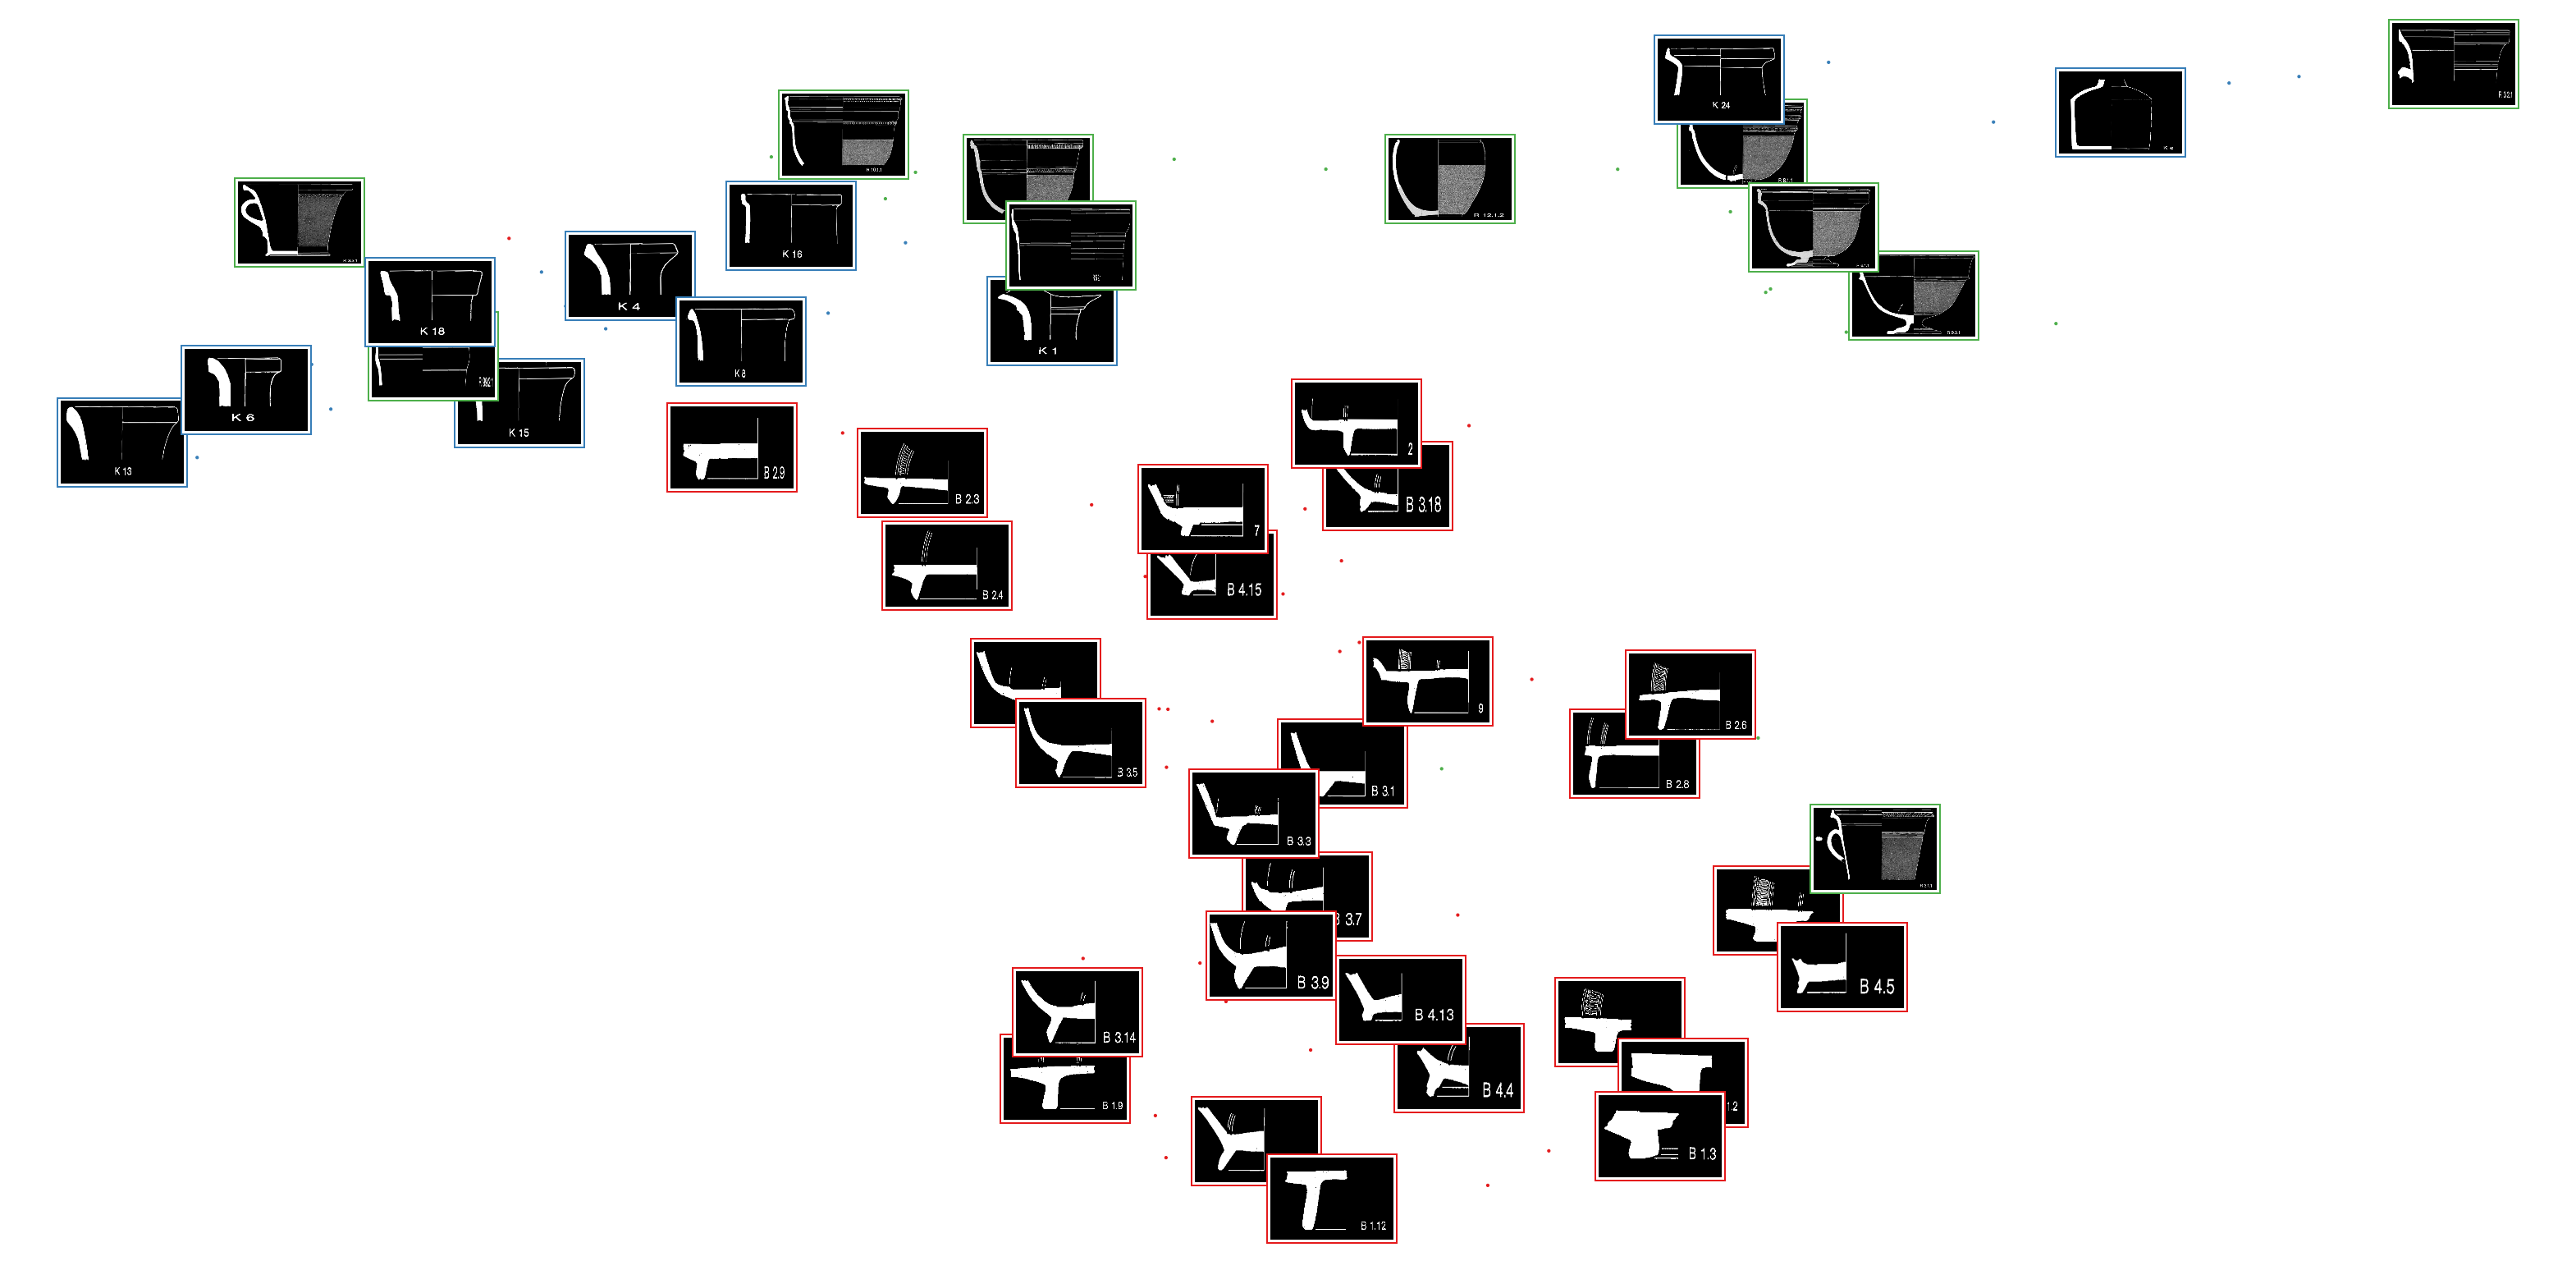

In [6]:
plt.figure(figsize=(56, 28))
#cmap = plt.cm.tab10
n = 3
from_list = mpl.colors.LinearSegmentedColormap.from_list
cmap = from_list(None, plt.cm.Set1(range(0,n)), n)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 1: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(cv.resize(origs[index],(150,100)), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

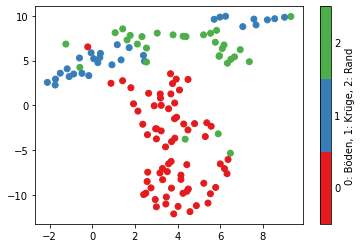

In [7]:
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap)
plt.clim(-0.5, n-0.5)
cb = plt.colorbar(ticks=range(0,3),label='0: Böden, 1: Krüge, 2: Rand')
cb.ax.tick_params(length=0)

In [8]:
#plt.imshow(images[14],cmap='gray')

## KNN

In [9]:


nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(descriptors)
#nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree',metric=phase_descriptor_distance).fit(descriptors)
distances, indices = nbrs.kneighbors(descriptors)

In [10]:
#index = 80
#print(indices[index])
#print(distances[index])

## 4NN

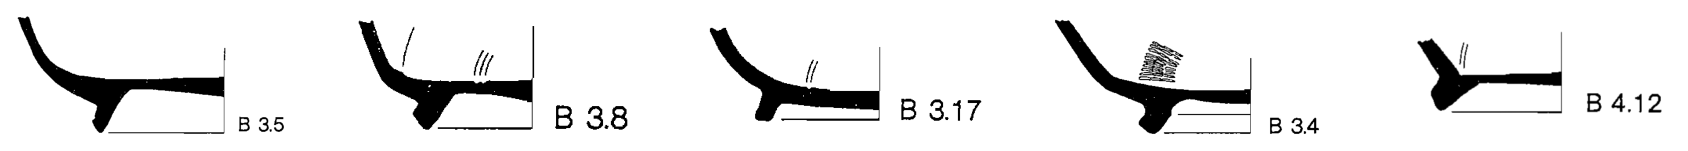

In [34]:
index = np.random.randint(0,len(origs))

f, axarr = plt.subplots(1,5,figsize=(30, 6))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(origs[indices[index,0]],cmap='gray')
#axarr[0].set_title('original')

axarr[1].imshow(origs[indices[index,1]],cmap='gray')

axarr[2].imshow(origs[indices[index,2]],cmap='gray')

axarr[3].imshow(origs[indices[index,3]],cmap='gray')
axarr[4].imshow(origs[indices[index,4]],cmap='gray')


## Show mean shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 592.5, 280.5, -0.5)

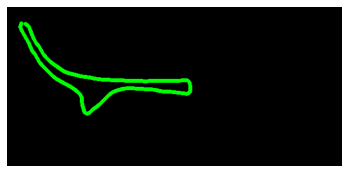

In [35]:
i1 = indices[index,0]
i2 = indices[index,1]
i3 = indices[index,2]
i4 = indices[index,3]
a = np.stack((d_mag[i1],d_mag[i2],d_mag[i3],d_mag[i4]))
m = np.mean(a,axis=0)
plt.imshow(draw_reconsturcted_descriptor(m,100,origs[i1].shape,thickness=5))
plt.axis('off')

# Curvature

In [13]:
curv = Curvature(images, descriptor_harmonics=40, 
contour_points=120)
curvatures = curv.run(signed=True)
conts = curv.get_reconstructed_fds()

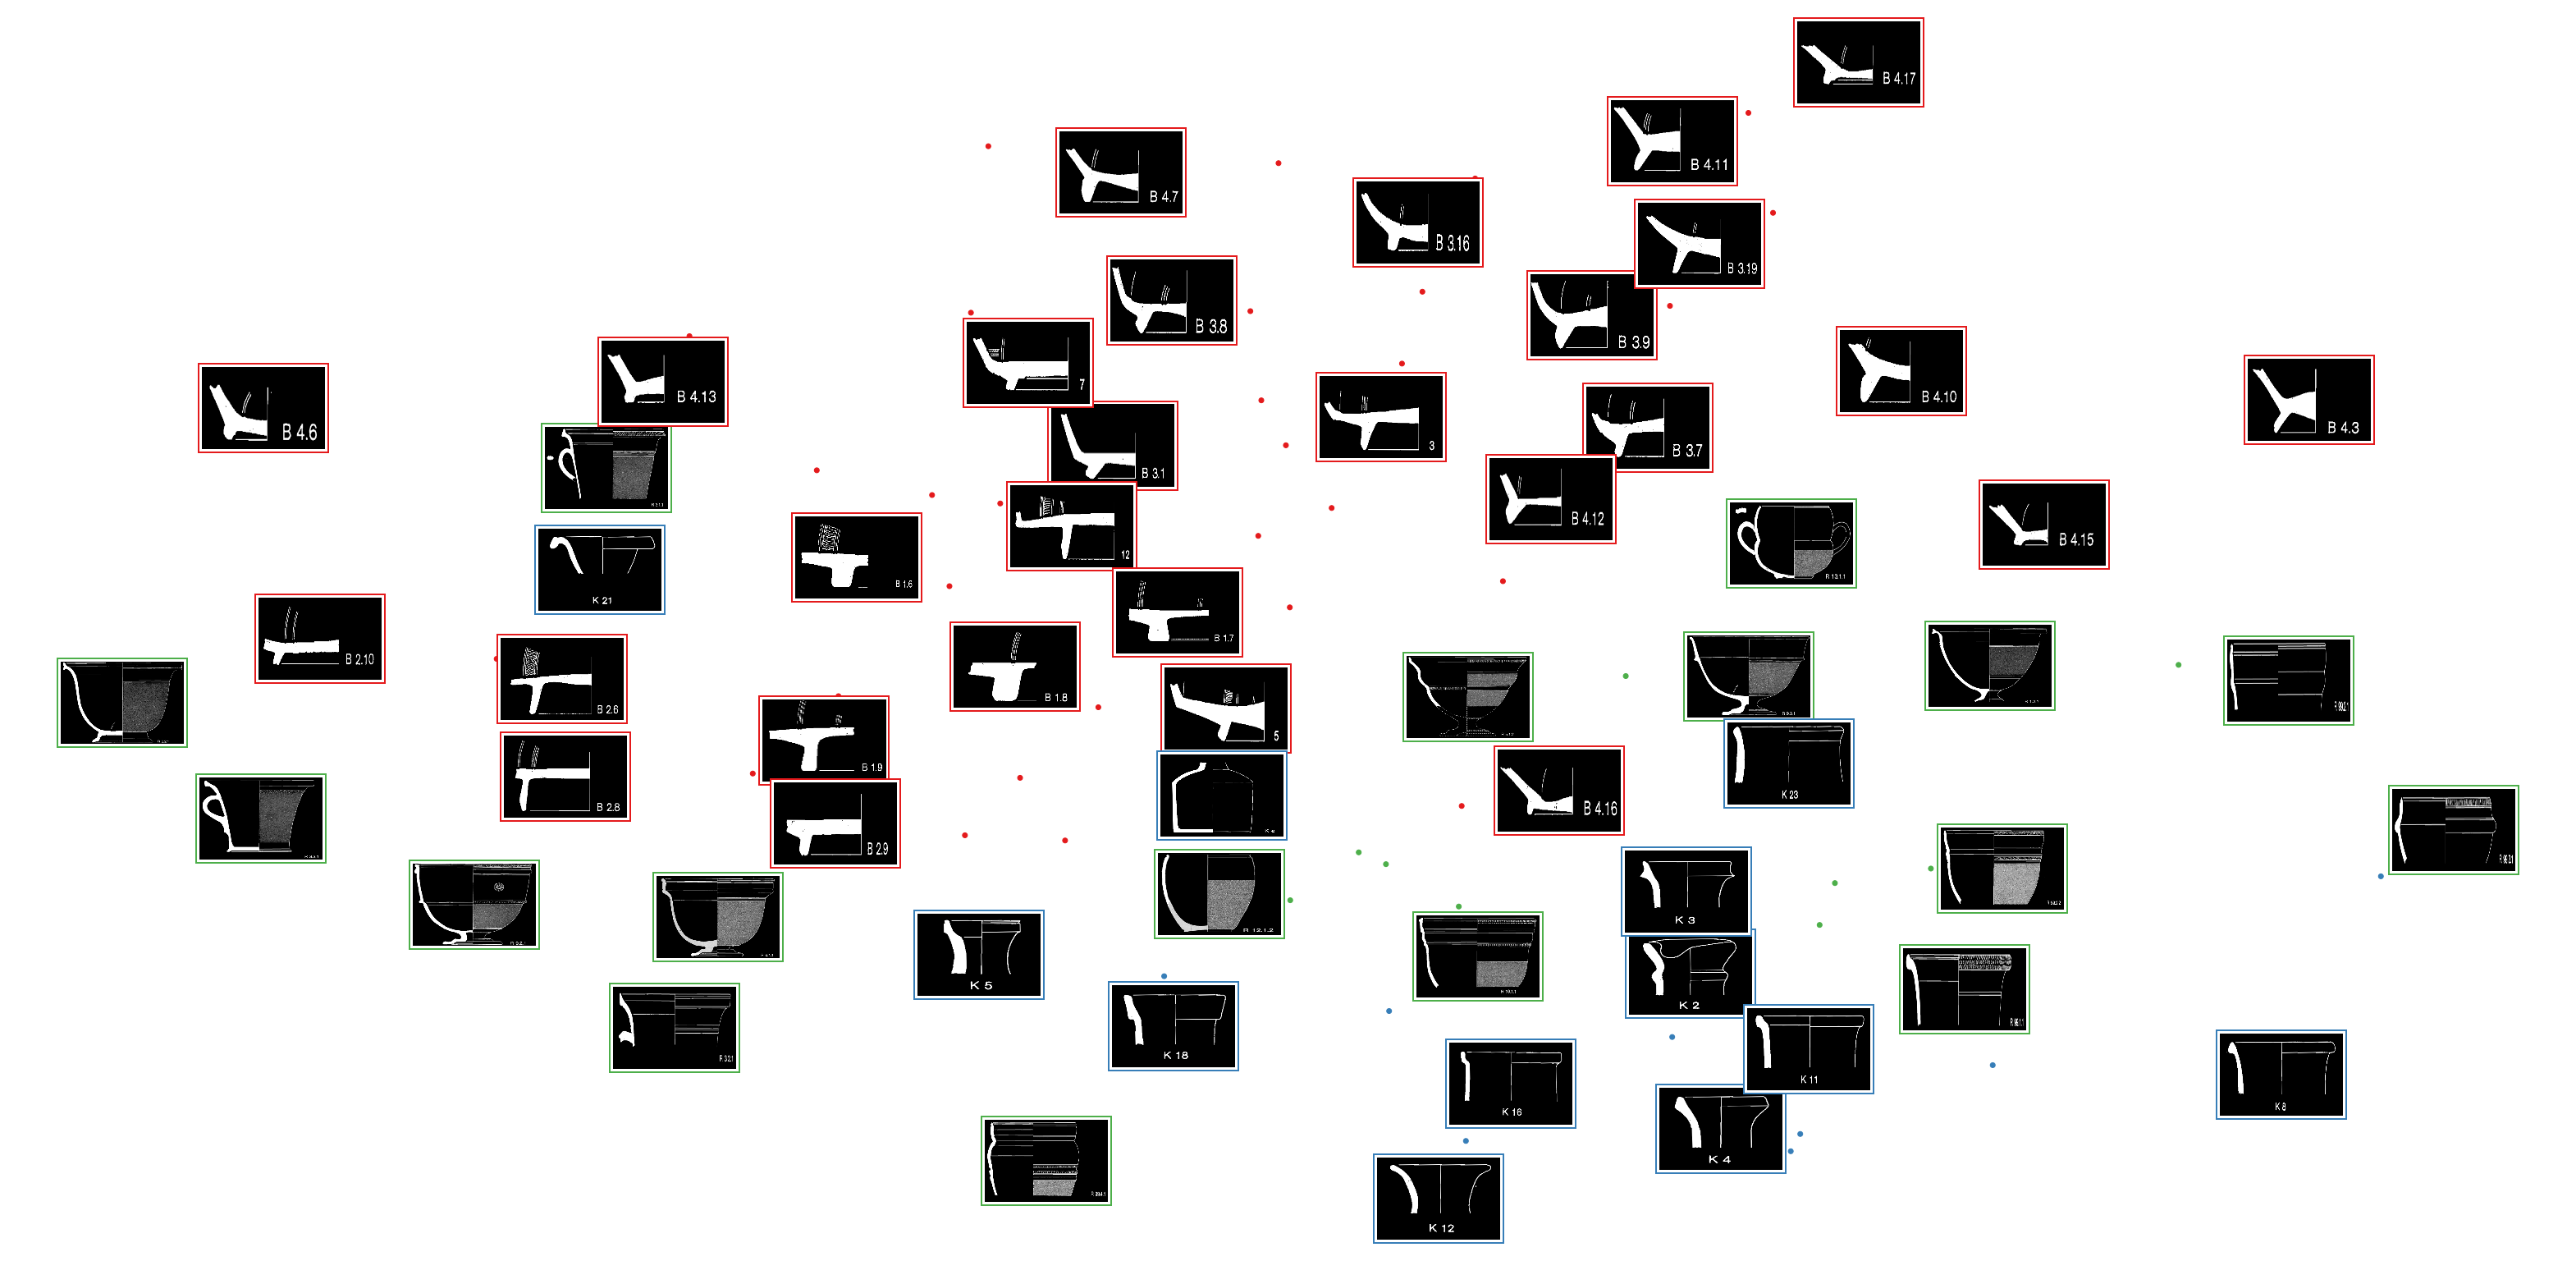

In [14]:
tsne_curv = TSNE()
X_2d = tsne_curv.fit_transform(curvatures)

plt.figure(figsize=(56, 28))
cmap = from_list(None, plt.cm.Set1(range(0,n)), n)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 1: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(cv.resize(origs[index],(150,100)), cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

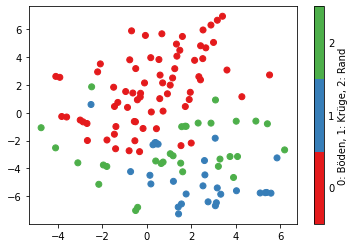

In [15]:
n = 3
from_list = mpl.colors.LinearSegmentedColormap.from_list
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap=cmap)
plt.clim(-0.5, n-0.5)
cb = plt.colorbar(ticks=range(0,n),label='0: Böden, 1: Krüge, 2: Rand')
cb.ax.tick_params(length=0)

## 4NN

In [22]:
nbrs_curv = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(curvatures)
distances_curv, indices_curv = nbrs_curv.kneighbors(curvatures)

<Figure size 4032x4032 with 0 Axes>

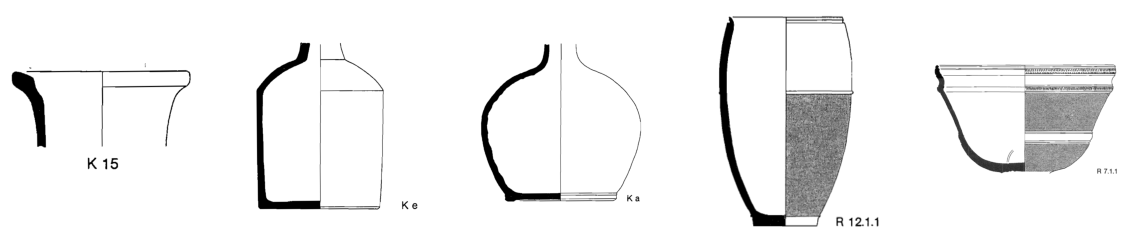

In [24]:
index = np.random.randint(0,len(origs))
fig = plt.figure(figsize=(56, 56))
f, axarr = plt.subplots(1,5,figsize=(20, 6))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(origs[indices_curv[index,0]],cmap='gray')

axarr[1].imshow(origs[indices_curv[index,1]],cmap='gray')
axarr[2].imshow(origs[indices_curv[index,2]],cmap='gray')
axarr[3].imshow(origs[indices_curv[index,3]],cmap='gray')
axarr[4].imshow(origs[indices_curv[index,4]],cmap='gray')